In [1]:
import functools
import os

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

In [3]:
import lib

In [4]:
def watermark(
    fig,
    text="preliminary",
):
    fig_width, fig_height = fig.get_size_inches()
    angle = np.degrees(np.arctan2(fig_height, fig_width))
    size = np.hypot(fig_width, fig_height) * 6 
    fig.text(
        0.5,
        0.5,
        text,
        color="k",
        alpha=0.1,
        fontsize=size,
        rotation=angle,
        horizontalalignment="center",
        verticalalignment="center",
    )

    return None

In [5]:
shear_step = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [6]:
redshift_sim = h5py.File(
    os.path.join(
        "/global/cfs/cdirs/des/boyan/sompz_output/y6_imsim_1000Tile/",
        shear_step,
        "noshear/weighted_pile3_oldtomo/sompz_y6_sim_noshear_1000Tile.hdf5",
    )
)

In [7]:
zlow = redshift_sim["catalog"]["sompz"]["pzdata"]["zlow"][:]
zhigh = redshift_sim["catalog"]["sompz"]["pzdata"]["zhigh"][:]

nz_sompz = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz = redshift_sim["catalog"]["sompz"]["pzdata"][f"bin{tomographic_bin}"][:]
    
    nz_sompz[tomographic_bin] = _nz / np.sum(_nz) / (zhigh - zlow)
    

In [8]:
shear_sim = h5py.File(
    lib.const.IMSIM_CATALOGS[shear_step],
)

In [9]:
truth_match = h5py.File(
    lib.const.MATCH_CATALOGS[shear_step],
)

In [10]:
_, shear_sim_index, redshift_sim_index = np.intersect1d(
    shear_sim["mdet/noshear"]["uid"],
    redshift_sim["catalog/sompz/noshear"]["coadd_object_id"],
    return_indices=True,
)

In [11]:
np.testing.assert_equal(
    shear_sim["mdet/noshear"]["uid"][:][shear_sim_index],
    redshift_sim["catalog/sompz/noshear"]["coadd_object_id"][:][redshift_sim_index],
)

In [12]:
bhat_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
bhat_sim[shear_sim_index] = redshift_sim["catalog/sompz/noshear"]["bhat"][:][redshift_sim_index]

In [13]:
cell_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
cell_sim[shear_sim_index] = redshift_sim["catalog/sompz/noshear"]["cell_wide"][:][redshift_sim_index]

In [14]:
weights_sim = lib.weights.get_shear_weights(shear_sim["mdet/noshear"])

In [15]:
response_sim = lib.response.get_shear_response(shear_sim["mdet/noshear"])

In [16]:
count_grid_sim, _, _ = stats.binned_statistic(
    cell_sim,
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)
occupancy_grid_sim = count_grid_sim / sum(count_grid_sim)

In [17]:
_weight_grid_sim, _, _ = stats.binned_statistic(
    cell_sim,
    weights_sim,
    statistic="sum",
    bins=lib.const.CELL_IDS,
)
weight_grid_sim = _weight_grid_sim / sum(_weight_grid_sim)

In [18]:
_response_grid_sim, _, _ = stats.binned_statistic(
    cell_sim,
    response_sim,
    statistic="mean",
    bins=lib.const.CELL_IDS,
)
response_grid_sim = _response_grid_sim

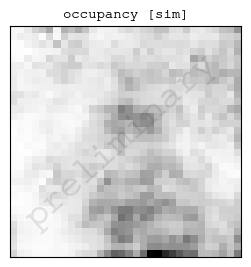

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    occupancy_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("occupancy [sim]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

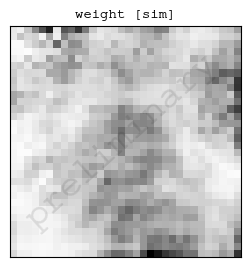

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    weight_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("weight [sim]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

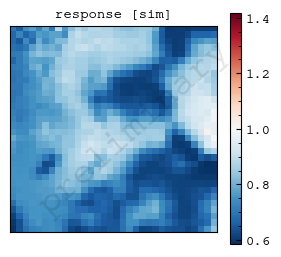

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

norm=mpl.colors.CenteredNorm(1)

m = axs.imshow(
    response_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
fig.colorbar(m)
axs.set_title("response [sim]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

---

In [22]:
shear_y6 = h5py.File(lib.const.Y6_SHEAR_CATALOG)
redshift_y6 = h5py.File(lib.const.Y6_REDSHIFT_CATALOG)

In [23]:
bhat_y6 = {}
cell_y6 = {}
weight_y6 = {}
response_y6 = {}

In [26]:
for mdet_step in ["noshear", "1p", "1m"]:
    _, _shear_y6_index, _redshift_y6_index = np.intersect1d(
        shear_y6["mdet"][mdet_step]["uid"],
        redshift_y6["sompz"][mdet_step]["coadd_object_id"],
        return_indices=True,
    )
    
    _bhat_y6 = np.full(shear_y6["mdet"][mdet_step]["uid"].shape, np.nan)
    _bhat_y6[_shear_y6_index] = redshift_y6["sompz"][mdet_step]["bhat"][:][_redshift_y6_index]
    
    _cell_y6 = np.full(shear_y6["mdet"][mdet_step]["uid"].shape, np.nan)
    _cell_y6[_shear_y6_index] = redshift_y6["sompz"][mdet_step]["cell_wide"][:][_redshift_y6_index]

    _weights_y6 = lib.weights.get_shear_weights(shear_y6["mdet"][mdet_step])

    _response_y6 = lib.response.get_shear_response(shear_y6["mdet"][mdet_step])

    bhat_y6[mdet_step] = _bhat_y6
    cell_y6[mdet_step] = _cell_y6
    weight_y6[mdet_step] = _weights_y6
    response_y6[mdet_step] = _response_y6

In [27]:
count_grid_y6, _, _ = stats.binned_statistic(
    cell_y6["noshear"],
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)
occupancy_grid_y6 = count_grid_y6 / sum(count_grid_y6)

In [28]:
_weight_grid_y6, _, _ = stats.binned_statistic(
    cell_y6["noshear"],
    weight_y6["noshear"],
    statistic="sum",
    bins=lib.const.CELL_IDS,
)
weight_grid_y6 = _weight_grid_y6 / sum(_weight_grid_y6)

In [29]:
g1_y6 = {
    mdet_step: shear_y6["mdet"][mdet_step]["gauss_g_1"][:]
    for mdet_step in lib.const.MDET_STEPS
}

g2_y6 = {
    mdet_step: shear_y6["mdet"][mdet_step]["gauss_g_2"][:]
    for mdet_step in lib.const.MDET_STEPS
}

In [30]:
# response map
mean_g1_y6 = {}
mean_g2_y6 = {}
for mdet_step in ["1p", "1m"]:
    _sum_weight, _, _ = stats.binned_statistic(
        cell_y6[mdet_step],
        weight_y6[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    _sum_g1, _, _ = stats.binned_statistic(
        cell_y6[mdet_step],
        weight_y6[mdet_step] * g1_y6[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g1_y6[mdet_step] = _sum_g1 / _sum_weight

    _sum_g2, _, _ = stats.binned_statistic(
        cell_y6[mdet_step],
        weight_y6[mdet_step] * g2_y6[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g2_y6[mdet_step] = _sum_g2 / _sum_weight

response_map_y6 = (mean_g1_y6["1p"] - mean_g1_y6["1m"]) / (2 * 0.01)

In [31]:
_response_grid_y6, _, _ = stats.binned_statistic(
    cell_y6["noshear"],
    response_y6["noshear"],
    statistic="mean",
    bins=lib.const.CELL_IDS,
)
response_grid_y6 = _response_grid_y6

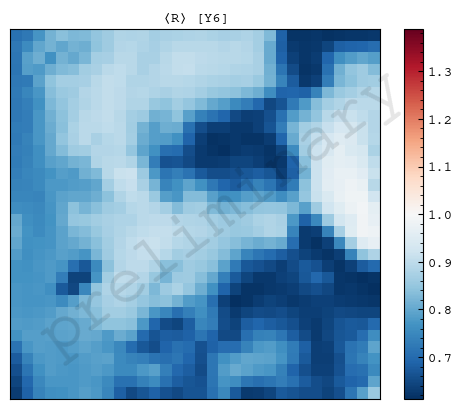

In [32]:
fig, axs = plt.subplots(1, 1)

norm=mpl.colors.CenteredNorm(1)

m = axs.imshow(
    response_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
fig.colorbar(m)

axs.set_xticks([])
axs.set_yticks([])
axs.set_title("$〈R〉$ [Y6]")

watermark(fig)

plt.show()

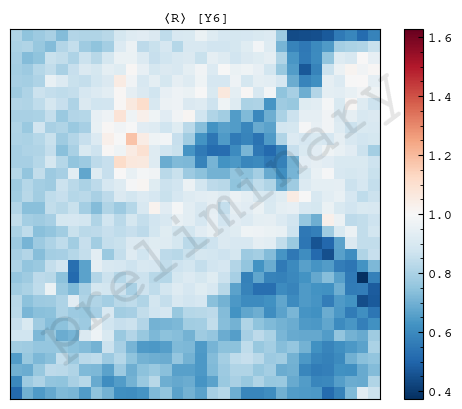

In [33]:
fig, axs = plt.subplots(1, 1)

norm=mpl.colors.CenteredNorm(1)

m = axs.imshow(
    response_map_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
fig.colorbar(m)

axs.set_xticks([])
axs.set_yticks([])
axs.set_title("$〈R〉$ [Y6]")

watermark(fig)

plt.show()

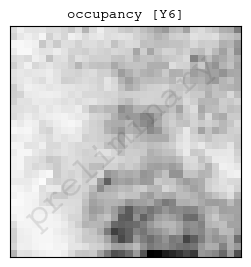

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    occupancy_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("occupancy [Y6]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

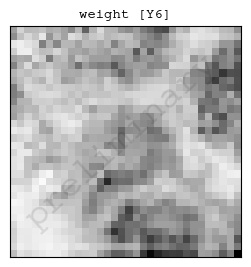

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    weight_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("weight [Y6]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

---

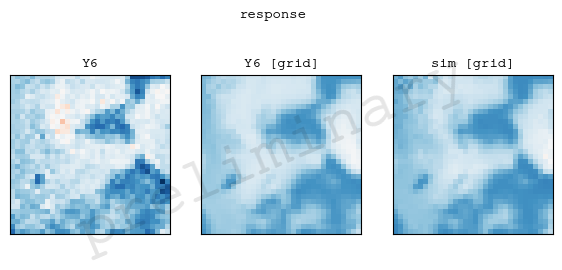

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(7, 3))

norm=mpl.colors.CenteredNorm(1)

axs[0].imshow(
    response_map_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
axs[0].set_title("Y6")

axs[1].imshow(
    response_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
axs[1].set_title("Y6 [grid]")

axs[2].imshow(
    response_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
axs[2].set_title("sim [grid]")


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("response")

watermark(fig)

plt.show()

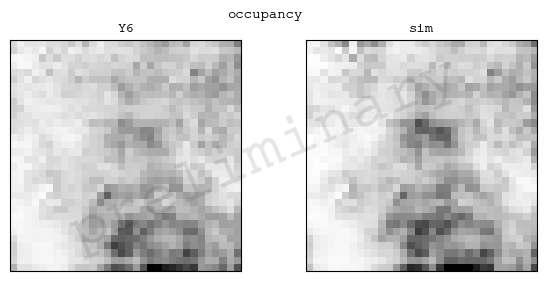

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

norm = mpl.colors.Normalize(vmin=0)

axs[0].imshow(
    occupancy_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[0].set_title("Y6")

axs[1].imshow(
    occupancy_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[1].set_title("sim")


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("occupancy")

watermark(fig)

plt.show()

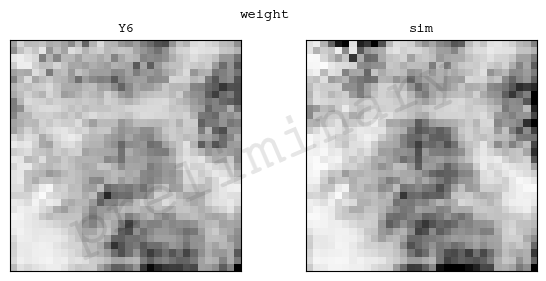

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

norm = mpl.colors.Normalize(vmin=0)

axs[0].imshow(
    weight_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[0].set_title("Y6")

axs[1].imshow(
    weight_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[1].set_title("sim")


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("weight")

watermark(fig)

plt.show()

In [39]:
np.var(occupancy_grid_y6), np.var(occupancy_grid_sim)

(3.671899408447018e-07, 5.205767734140469e-07)

In [40]:
np.var(weight_grid_y6), np.var(weight_grid_sim)

(2.408401797308064e-07, 3.7646127115587887e-07)

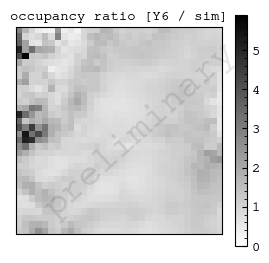

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    (occupancy_grid_y6 / occupancy_grid_sim).reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("occupancy ratio [Y6 / sim]")

fig.colorbar(im, ax=axs)

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

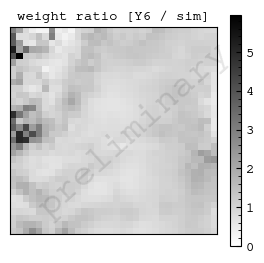

In [42]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    (weight_grid_y6 / weight_grid_sim).reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("weight ratio [Y6 / sim]")

fig.colorbar(im, ax=axs)

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

---

In [89]:
# extend the last bin and "pileup"
zedges = np.copy(lib.const.ZEDGES)
zedges[-1] = 4.

_sum_weight, _, _, _ = stats.binned_statistic_2d(
    cell_sim,
    truth_match["mdet/noshear"]["z"],
    weights_sim,
    statistic="sum",
    bins=[lib.const.CELL_IDS, zedges],
)

# manually force n(0) = 0
nz[:, 0] = 0

# renormalize
nz = _sum_weight / np.sum(_sum_weight, axis=1)[:, np.newaxis]
# nz = _sum_weight / np.diff(lib.const.ZEDGES)
# nz /= nz.sum()

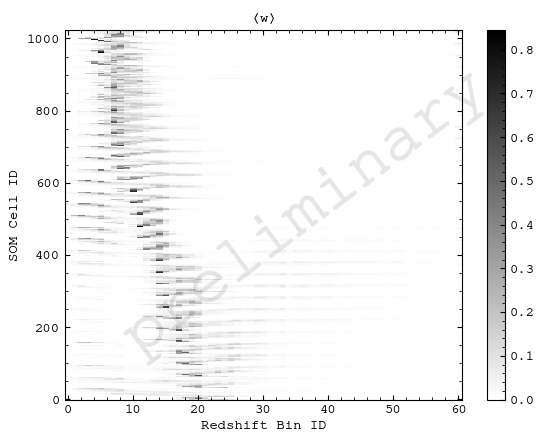

In [90]:
fig, axs = plt.subplots(1, 1,)

im = axs.imshow(
    nz,
    origin="lower",
    vmin=0
)
axs.set_xlabel("Redshift Bin ID")
axs.set_ylabel("SOM Cell ID")
axs.set_title("$〈w〉$")

axs.set_aspect("auto")

fig.colorbar(im, ax=axs)

watermark(fig)

plt.show()

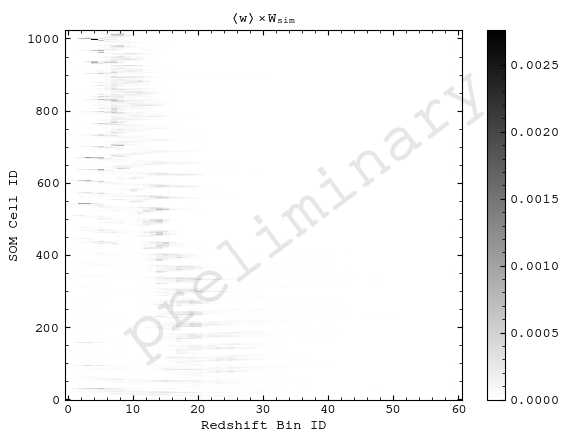

In [91]:
fig, axs = plt.subplots(1, 1,)

im = axs.imshow(
    nz * weight_grid_sim[:, np.newaxis],
    origin="lower",
    vmin=0
)
axs.set_xlabel("Redshift Bin ID")
axs.set_ylabel("SOM Cell ID")
axs.set_title("$〈w〉 \\times W_{sim}$")

axs.set_aspect("auto")

fig.colorbar(im, ax=axs)

watermark(fig)

plt.show()

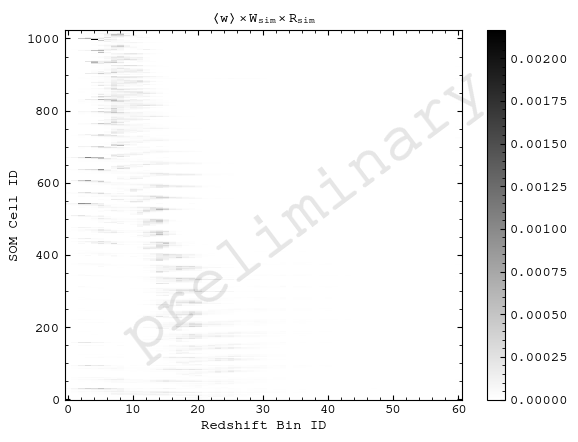

In [92]:
fig, axs = plt.subplots(1, 1,)

im = axs.imshow(
    nz * weight_grid_sim[:, np.newaxis] * response_grid_sim[:, np.newaxis],
    origin="lower",
    vmin=0
)
axs.set_xlabel("Redshift Bin ID")
axs.set_ylabel("SOM Cell ID")
axs.set_title("$〈w〉 \\times W_{sim} \\times R_{sim}$")

axs.set_aspect("auto")

fig.colorbar(im, ax=axs)

watermark(fig)

plt.show()

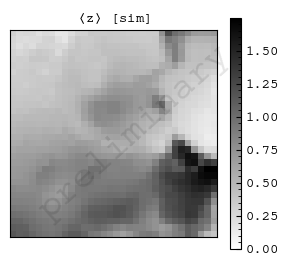

In [93]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    (
        np.sum(lib.const.ZVALS * nz, axis=1) 
        / np.sum(nz, axis=1)
    ).reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0
)
axs.set_title("$〈z〉$ [sim]")

fig.colorbar(im, ax=axs)

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

---

In [94]:
cell_assignments = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments[tomographic_bin] = np.unique(
        cell_sim[bhat_sim == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments.values()
        ],
    )
) == 0

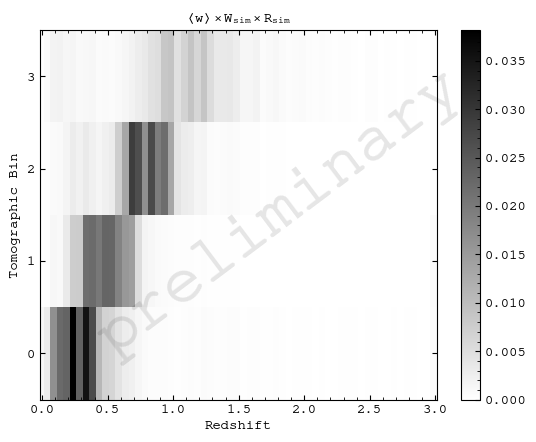

In [95]:
fig, axs = plt.subplots(1, 1,)

im = axs.pcolormesh(
    lib.const.ZVALS,
    lib.const.TOMOGRAPHIC_BINS,
    np.array(
        [
            np.sum(
                (nz * weight_grid_sim[:, np.newaxis] * response_grid_sim[:, np.newaxis])[cell_assignments[tomographic_bin]],
                axis=0,
            )
            for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
        ]
    ),
    vmin=0
)
axs.set_xlabel("Redshift")
axs.set_ylabel("Tomographic Bin")
axs.set_title("$〈w〉 \\times W_{sim} \\times R_{sim}$")

axs.set_aspect("auto")

fig.colorbar(im, ax=axs)

# axs.set_xticks([])
axs.set_yticks([0, 1, 2, 3])
axs.set_yticks([], minor=True)

watermark(fig)

plt.show()

---

# Unweighted

In [96]:
nz_tomo = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_tomo[tomographic_bin] = np.sum(
        nz[cell_assignments[tomographic_bin]],
        axis=0,
    )
    
    # manually force n(0) = 0
    nz_tomo[tomographic_bin][0] = 0

    # renormalize
    nz_tomo[tomographic_bin] = nz_tomo[tomographic_bin] / np.sum(nz_tomo[tomographic_bin]) / np.diff(lib.const.ZEDGES)

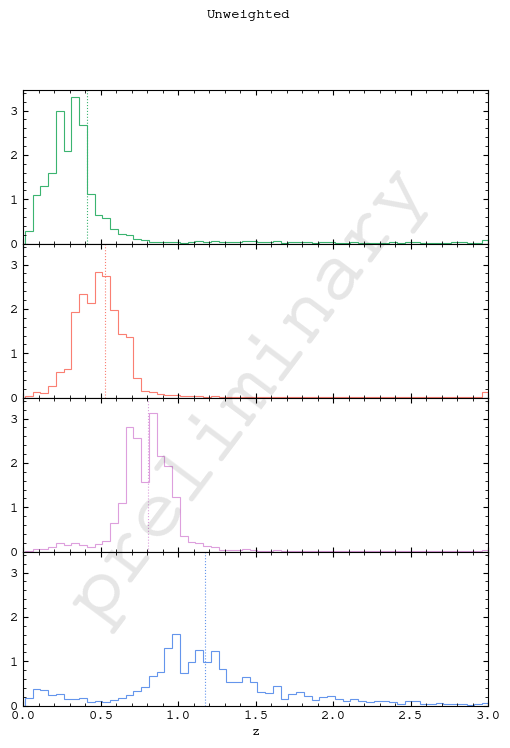

In [97]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo[i]),
        c=tomo_colors[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_tomo[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

fig.suptitle("Unweighted")

watermark(fig)

plt.show()

# Statistical Weights

In [98]:
nz_tomo_w = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_tomo_w[tomographic_bin] = np.sum(
        nz[cell_assignments[tomographic_bin]] \
        * weight_grid_sim[cell_assignments[tomographic_bin], np.newaxis],
        axis=0,
    ) / np.sum(
        weight_grid_sim[cell_assignments[tomographic_bin]],
    )
    
    # manually force n(0) = 0
    nz_tomo_w[tomographic_bin][0] = 0

    # renormalize
    nz_tomo_w[tomographic_bin] = nz_tomo_w[tomographic_bin] / np.sum(nz_tomo_w[tomographic_bin]) / np.diff(lib.const.ZEDGES)

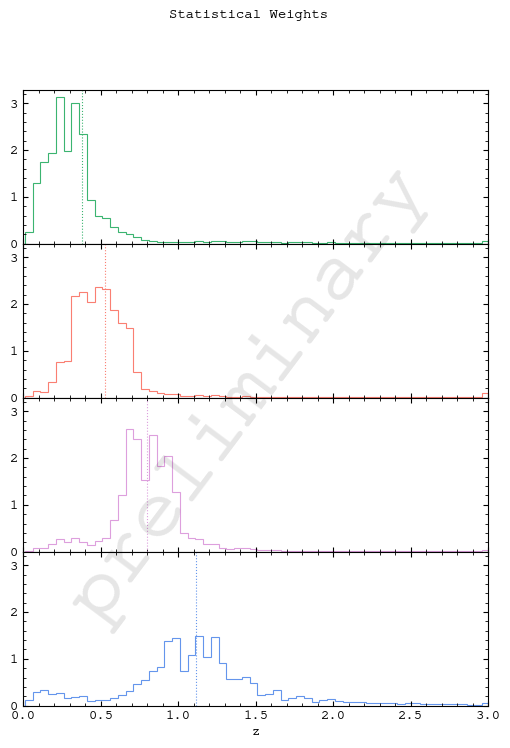

In [99]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_w[i]),
        c=tomo_colors[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_tomo_w[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

fig.suptitle("Statistical Weights")

watermark(fig)

plt.show()

# Statistical Weights & Response

In [118]:
nz_tomo_wR = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_tomo_wR[tomographic_bin] = np.sum(
        nz[cell_assignments[tomographic_bin]] \
        * response_grid_sim[cell_assignments[tomographic_bin], np.newaxis] \
        * weight_grid_sim[cell_assignments[tomographic_bin], np.newaxis],
        axis=0,
    ) / np.sum(
        response_grid_sim[cell_assignments[tomographic_bin]] \
        * weight_grid_sim[cell_assignments[tomographic_bin]],
    )
    
    # manually force n(0) = 0
    nz_tomo_wR[tomographic_bin][0] = 0

    # renormalize
    nz_tomo_wR[tomographic_bin] = nz_tomo_wR[tomographic_bin] / np.sum(nz_tomo_wR[tomographic_bin]) / np.diff(lib.const.ZEDGES)

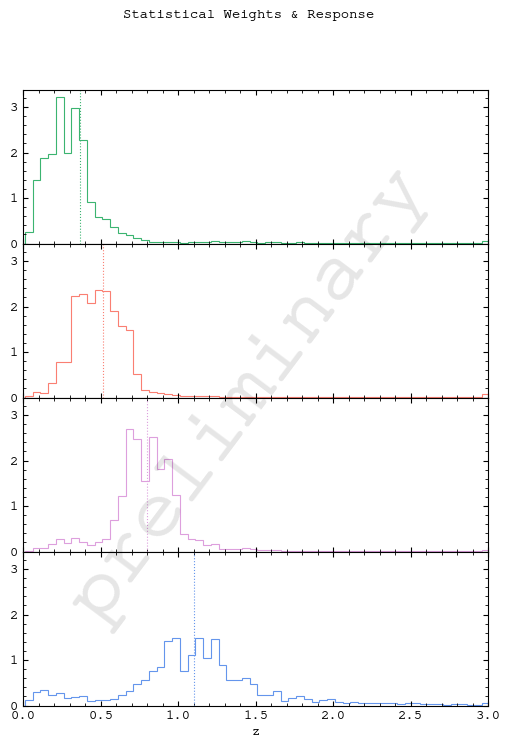

In [119]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_wR[i]),
        c=tomo_colors[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_tomo_wR[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

fig.suptitle("Statistical Weights & Response")

watermark(fig)

plt.show()

# Statistical Weights & Response & Occupancy Ratio

In [102]:
nz_tomo_wRo = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_tomo_wRo[tomographic_bin] = np.sum(
        nz[cell_assignments[tomographic_bin]] \
        * response_grid_sim[cell_assignments[tomographic_bin], np.newaxis] \
        * (occupancy_grid_y6 / occupancy_grid_sim)[cell_assignments[tomographic_bin], np.newaxis] \
        * weight_grid_sim[cell_assignments[tomographic_bin], np.newaxis],
        axis=0,
    ) / np.sum(
        response_grid_sim[cell_assignments[tomographic_bin], np.newaxis] \
        * weight_grid_sim[cell_assignments[tomographic_bin]],
    )
    
    # manually force n(0) = 0
    nz_tomo_wRo[tomographic_bin][0] = 0

    # renormalize
    nz_tomo_wRo[tomographic_bin] = nz_tomo_wRo[tomographic_bin] / np.sum(nz_tomo_wRo[tomographic_bin]) / np.diff(lib.const.ZEDGES)

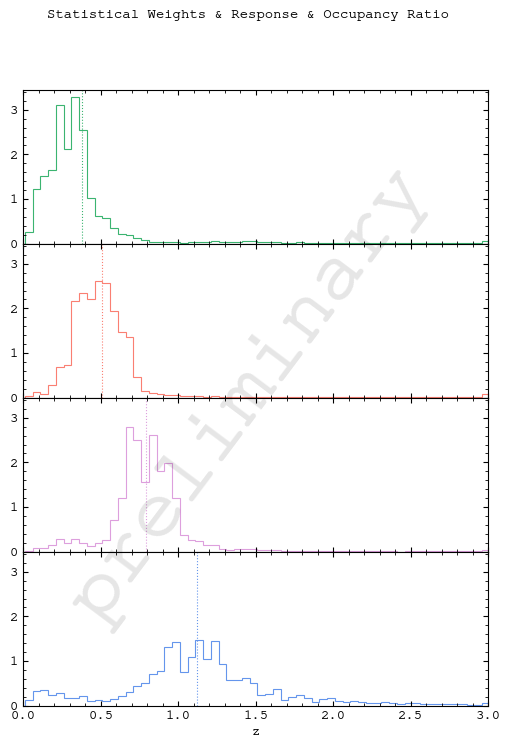

In [103]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_wRo[i]),
        c=tomo_colors[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_tomo_wRo[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

fig.suptitle("Statistical Weights & Response & Occupancy Ratio")

watermark(fig)

plt.show()

# Statistical Weights & Response & Weight Ratio

In [104]:
nz_tomo_wRw = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_tomo_wRw[tomographic_bin] = np.sum(
        nz[cell_assignments[tomographic_bin]] \
        * response_grid_sim[cell_assignments[tomographic_bin], np.newaxis] \
        * (weight_grid_y6 / weight_grid_sim)[cell_assignments[tomographic_bin], np.newaxis] \
        * weight_grid_sim[cell_assignments[tomographic_bin], np.newaxis],
        axis=0,
    ) / np.sum(
        response_grid_sim[cell_assignments[tomographic_bin], np.newaxis] \
        * weight_grid_sim[cell_assignments[tomographic_bin]],
    )
    
    # manually force n(0) = 0
    nz_tomo_wRw[tomographic_bin][0] = 0
    
    # renormalize
    nz_tomo_wRw[tomographic_bin] = nz_tomo_wRw[tomographic_bin] / np.sum(nz_tomo_wRw[tomographic_bin]) / np.diff(lib.const.ZEDGES)

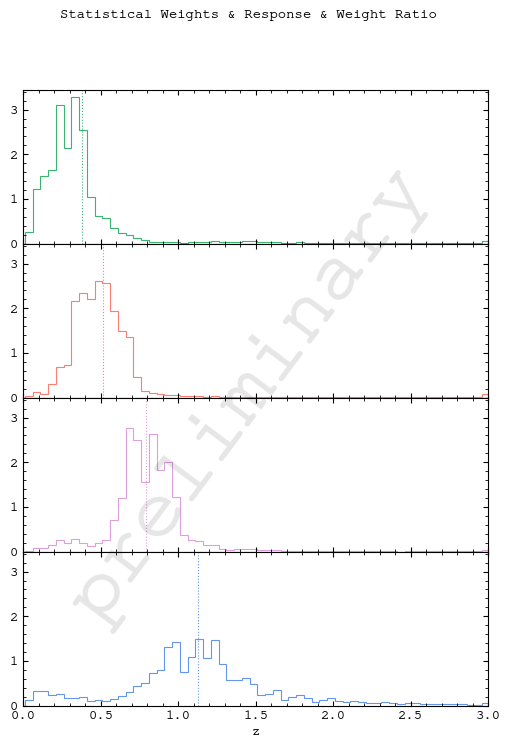

In [105]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_wRw[i]),
        c=tomo_colors[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_tomo_wRw[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

fig.suptitle("Statistical Weights & Response & Weight Ratio")

watermark(fig)

plt.show()

---

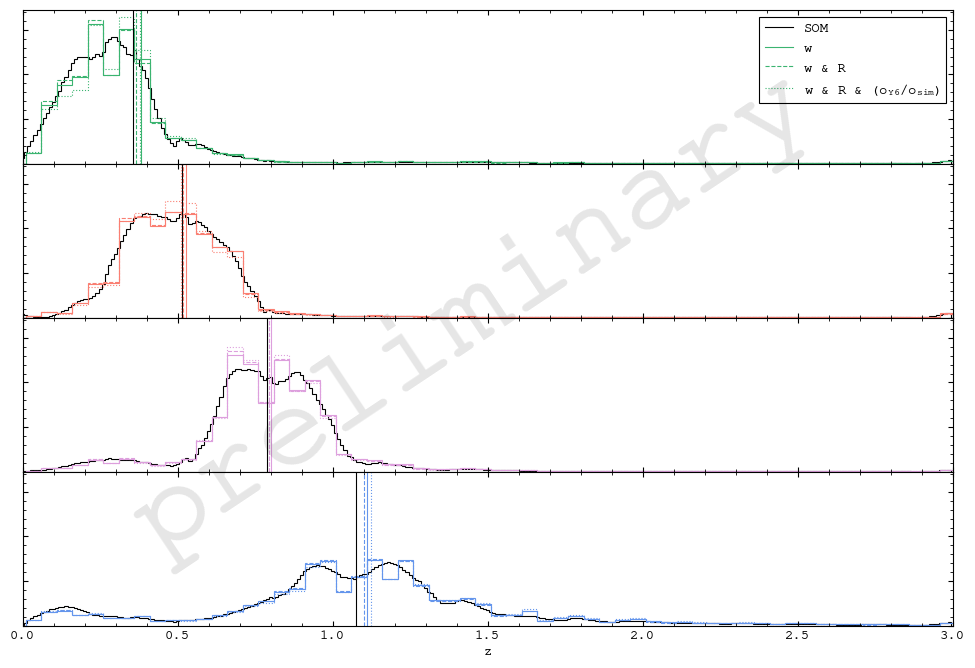

In [120]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average((zlow + zhigh) / 2, weights=nz_sompz[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_sompz[i],
        edges=[*zlow, zhigh[-1]],
        ec="k",
        ls="-",
        label="SOM",
    )
    
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_w[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_tomo_w[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
        ls="-",
        label="w",
    )
    
    axs[i].stairs(
        nz_tomo_wR[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
        ls="--",
        label="w & R",
    )
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_wR[i]),
        c=tomo_colors[i],
        ls="--",
    )
    
    axs[i].stairs(
        nz_tomo_wRo[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
        ls=":",
        label="w & R & ($o_{Y6}/o_{sim}$)",
    )
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_wRo[i]),
        c=tomo_colors[i],
        ls=":",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

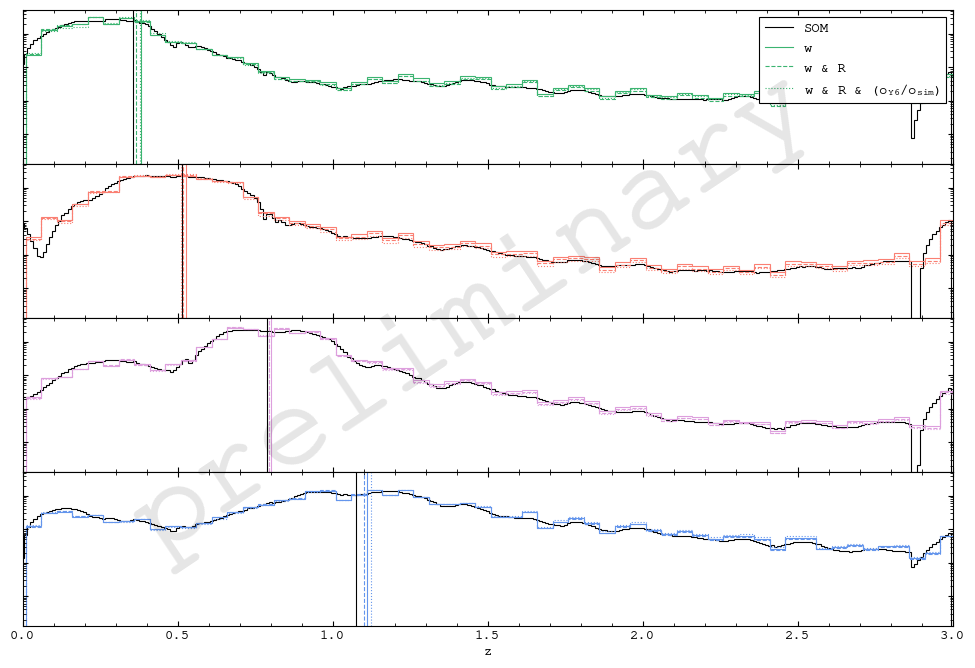

In [121]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average((zlow + zhigh) / 2, weights=nz_sompz[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_sompz[i],
        edges=[*zlow, zhigh[-1]],
        ec="k",
        ls="-",
        label="SOM",
    )
    
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_w[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_tomo_w[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
        ls="-",
        label="w",
    )
    
    axs[i].stairs(
        nz_tomo_wR[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
        ls="--",
        label="w & R",
    )
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_wR[i]),
        c=tomo_colors[i],
        ls="--",
    )
    
    axs[i].stairs(
        nz_tomo_wRo[i],
        edges=lib.const.ZEDGES,
        ec=tomo_colors[i],
        ls=":",
        label="w & R & ($o_{Y6}/o_{sim}$)",
    )
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo_wRo[i]),
        c=tomo_colors[i],
        ls=":",
    )
    

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

In [122]:
print("mean z")
print(
    f"bin"
    f"\tSOMPZ"
    f"\tw (sim)"
    f"\tw (sim) & R (sim)"
    f"\tw (sim) & R (sim) & o/o"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average((zlow + zhigh) / 2, weights=nz_sompz[i]) :.4f}"
        f"\t{np.average(lib.const.ZVALS, weights=nz_tomo_w[i]) :.4f}"
        f"\t{np.average(lib.const.ZVALS, weights=nz_tomo_wR[i]) :.4f}\t\t"
        f"\t{np.average(lib.const.ZVALS, weights=nz_tomo_wRo[i]) :.4f}\t\t"
    )
 

mean z
bin	SOMPZ	w (sim)	w (sim) & R (sim)	w (sim) & R (sim) & o/o
0	0.3552	0.3817	0.3645			0.3787		
1	0.5157	0.5259	0.5176			0.5113		
2	0.7895	0.8014	0.7953			0.7935		
3	1.0751	1.1119	1.1026			1.1241		
